<a href="https://colab.research.google.com/github/EbsHirani/SkinCancer/blob/master/SkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.chdir("/content/drive/My Drive/SkinCancer")

In [0]:
os.chdir("Data/datasets/kmader/skin-cancer-mnist-ham10000")

In [11]:
!unzip \*.zip


Archive:  skin-cancer-mnist-ham10000.zip
replace HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: HAM10000_metadata.csv   
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_28_28_RGB.csv    


In [12]:
os.listdir()

['hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'skin-cancer-mnist-ham10000.zip',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'ham10000_images_part_1',
 'ham10000_images_part_2',
 'best_model.h5',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv']

In [0]:
from glob import glob

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob('*/*.*')+glob("*.*")+glob("*/*/8.jpg")}

In [14]:
# len([x for x in glob("*/*.jpg")])
len(imageid_path_dict)

10022

In [15]:
import pandas as pd
import numpy as np
metadata = pd.read_csv("HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Lambda, Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Convolution2D , MaxPooling2D, Activation

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
def read_image(file_path):
    img = img_to_array(load_img(file_path,target_size = (64,64)))

    return img
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, 64, 64,3), dtype=np.float32)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
    return data
image_arr = prep_data(metadata["image_id"].map(lambda x: imageid_path_dict[x]).values)


In [0]:
image_arr.shape

(10015, 64, 64, 3)

In [0]:
metadata["dx"] = metadata["dx"].astype('category')
labels = metadata["dx"].cat.codes.values

In [0]:
labels = to_categorical(labels)

In [0]:
labels.shape

(10015, 7)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Ailment Count:')

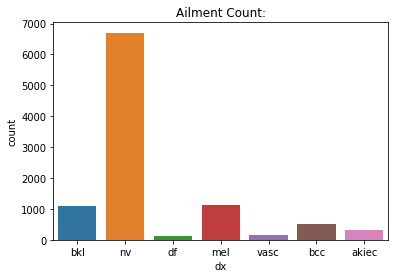

In [0]:
sns.countplot(x = "dx", data = metadata)
plt.title("Ailment Count:")


In [0]:
image_arr.shape

(10015,)

In [0]:
model = Sequential([
    BatchNormalization(input_shape=(64,64,3)),
    Dropout(0.2),
    Convolution2D(32,(3,3), activation = 'relu'),
    BatchNormalization(axis = 3),
    Convolution2D(32,(3,3),activation = 'relu'),
    MaxPooling2D(data_format='channels_last'),
    BatchNormalization(axis = 3),
    Convolution2D(64,(3,3),activation = 'relu'),
    BatchNormalization(axis=3),
    Convolution2D(64,(3,3),activation = 'relu'),
    MaxPooling2D(data_format='channels_last'),
    Convolution2D(128,(3,3),activation='relu'),
    #MaxPooling2D(data_format='channels_last'),
    BatchNormalization(axis = 3),
    Convolution2D(128,(3,3),activation='relu'),
    #MaxPooling2D(data_format='channels_last'),
    BatchNormalization(axis = 3),
    Convolution2D(256,(3,3),activation='relu'),
    #MaxPooling2D(data_format='channels_last'),
    BatchNormalization(axis = 3),
    Convolution2D(256,(3,3),activation='relu'),
    #MaxPooling2D(data_format='channels_last'),
    Flatten(),
    BatchNormalization(),

    Dense(256,activation = 'relu'),
    BatchNormalization(),
    
    Dense(7, activation = 'sigmoid'),
])
model.load_weights("model.h5")
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.optimizer.lr=0.005




In [0]:
from sklearn.model_selection import train_test_split
gen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
 
xtrain,xval, ytrain, yval = train_test_split(image_arr, labels ,test_size = 0.10, random_state = 42)
batches=gen.flow(xtrain,ytrain,batch_size = 16)
valbatches = gen.flow(xval,yval,batch_size = 16)

In [0]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=10, validation_data=valbatches, validation_steps=valbatches.n,callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto'),ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)])

Epoch 1/10
   5/9013 [..............................] - ETA: 3:18 - loss: 0.5463 - accuracy: 0.8500

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


9013/9013 [==============================] - 264s 29ms/step - loss: 0.6484 - accuracy: 0.7618 - val_loss: 0.8252 - val_accuracy: 0.7098
Epoch 2/10
9013/9013 [==============================] - 263s 29ms/step - loss: 0.6318 - accuracy: 0.7664 - val_loss: 1.0288 - val_accuracy: 0.6734
Epoch 3/10
1357/9013 [===>..........................] - ETA: 3:24 - loss: 0.6220 - accuracy: 0.7669